#**Traitement des images**
Le traitement d'image consiste à manipuler et analyser des images pour en extraire des informations utiles ou les améliorer. Il inclut des techniques comme le filtrage, l'amélioration de contraste, la détection des contours, et la segmentation des objets. Utilisé dans des domaines comme la vision par ordinateur, la reconnaissance faciale ou la médecine, le traitement d'image permet de convertir des données visuelles brutes en formats compréhensibles pour des analyses automatisées ou humaines.




##**Les différentes techniques de traitement d'image**
On va parler ici de comment analyser des images avec des histogrammes. On va aussi parler de comment utiliser ces histogrammes pour effectuer quelques techniques de base de retouche d’image.




### **1.  Les Histogrammes**
Les histogrammes d'image représentent la distribution des niveaux de gris ou des couleurs d'une image. Ils montrent la fréquence de chaque intensité de pixel, allant de 0 (noir) à 255 (blanc) pour les images en niveaux de gris, ou sur trois canaux (rouge, vert, bleu) pour les images en couleur. Utilisés en traitement d'image, les histogrammes aident à analyser le contraste, la luminosité ou les couleurs d'une image, et permettent des ajustements comme l'égalisation pour améliorer la qualité visuelle.



In [45]:
#Importation des bibliothèques python
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import exposure, transform, morphology, data
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import numpy as np
import cv2
import pandas as pd
from skimage.filters import threshold_mean, threshold_otsu
import math
from scipy import signal

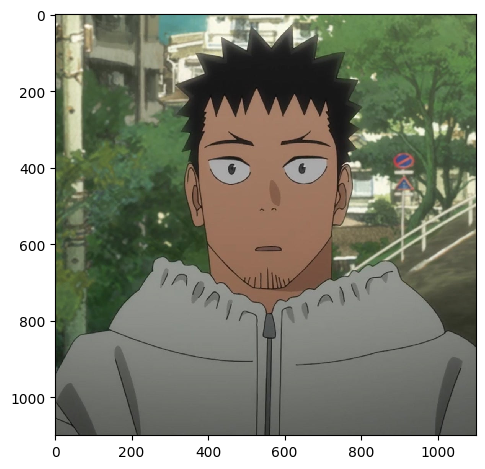

In [2]:
#Lecture de l'image
image = imread('376114.jpeg')
imshow(image)

Another method


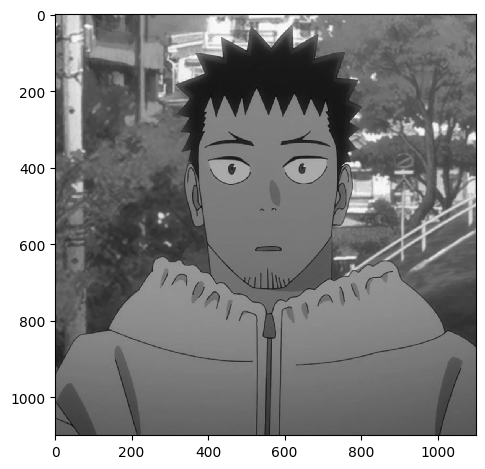

In [3]:
#Convertissons l'image en niveau de gris
image_gray = rgb2gray(image)
image_gray_1 = imread('376114.jpeg', as_gray=True)

imshow(image_gray)
print("Another method")
imshow(image_gray_1)

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


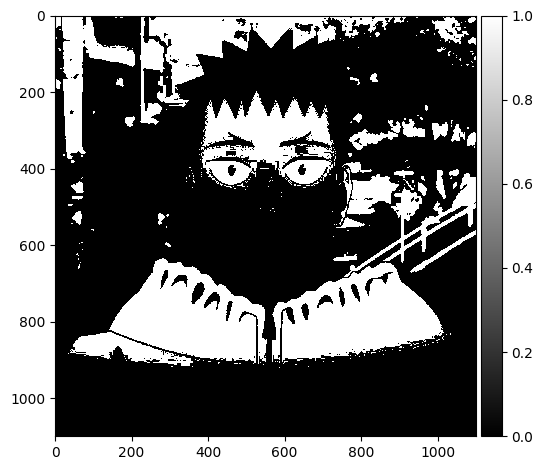

In [4]:
#Convertissons en noir et blanc
image_nb = np.where(image_gray > 0.5, 1, 0)
imshow(image_nb, cmap=plt.get_cmap('gray'))

####**Histogramme avec Scikit-Image**

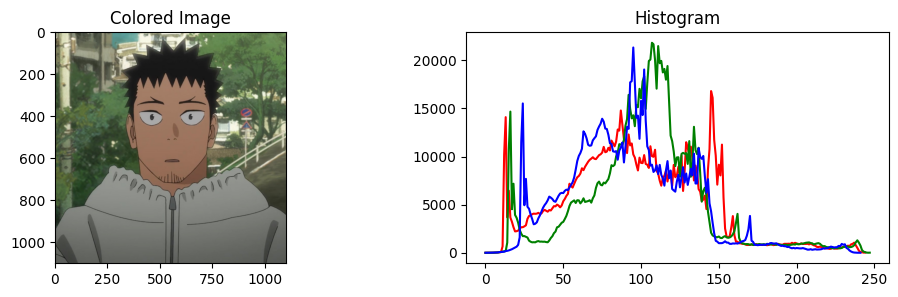

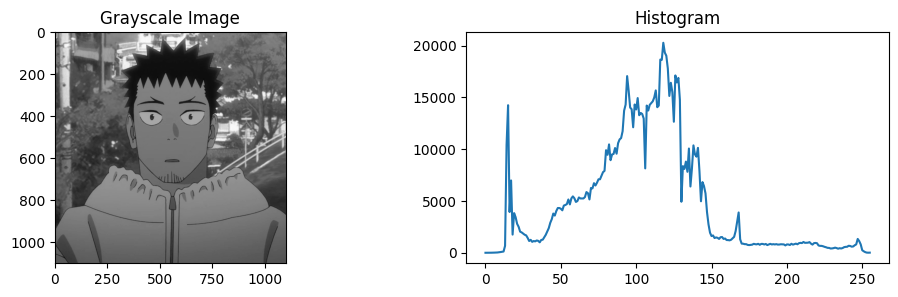

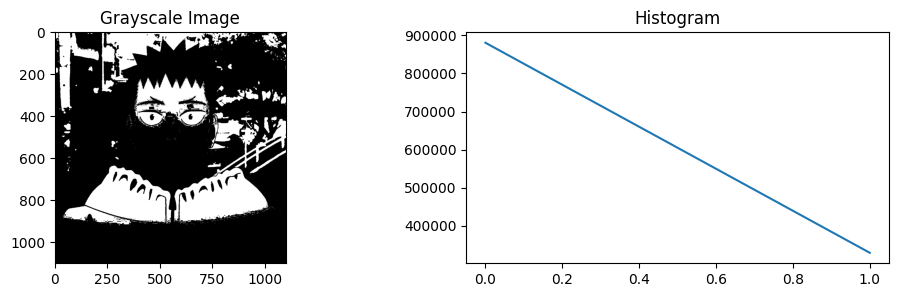

In [5]:
def imageHist(image):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    if (image.ndim == 2):
        # Grascale Image
        axis[0].imshow(image, cmap=plt.get_cmap('gray'))
        axis[1].set_title('Histogram')
        axis[0].set_title('Grayscale Image')
        hist = exposure.histogram(image)
        axis[1].plot(hist[0])
    else:
        # Color image
        axis[0].imshow(image, cmap='gray')
        axis[1].set_title('Histogram')
        axis[0].set_title('Colored Image')
        rgbcolors = ['red', 'green', 'blue']
        for i, mycolor in enumerate(rgbcolors):
            axis[1].plot(exposure.histogram(image[...,i])[0], color=mycolor)

imageHist(image)
imageHist(image_gray)
imageHist(image_nb)


####**Histogramme avec OpenCV**

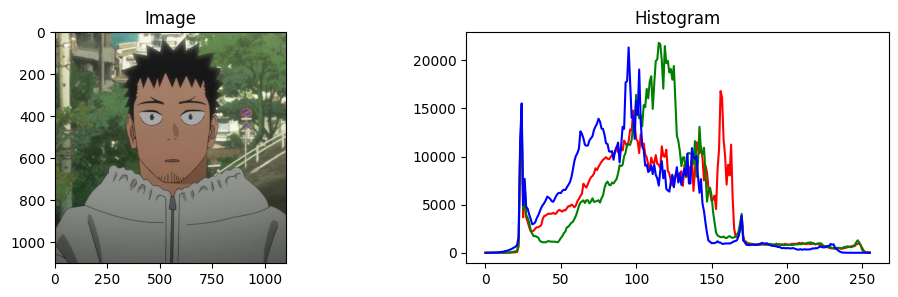

In [6]:
def histogramOpenCV(_img):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    axis[0].imshow(_img)
    axis[1].set_title('Histogram')
    axis[0].set_title('Image')
    rgbcolors = ['red', 'green', 'blue']
    for i,col in enumerate(rgbcolors):
        histr = cv2.calcHist([_img],[i],None,[256],[0,256])
        axis[1].plot(histr,color = col)

histogramOpenCV(image)

##Voyons comment tout ça marche avec scikit-image

---



###**2- Seuillage d'image**
Le seuillage d'image est une technique de traitement d'image qui consiste à convertir une image en niveaux de gris en une image binaire (noir et blanc). Elle fonctionne en définissant un seuil d'intensité de pixel : tous les pixels avec une intensité supérieure au seuil sont définis comme blancs, et ceux avec une intensité inférieure deviennent noirs.

Cette méthode est souvent utilisée pour la segmentation d'objets dans une image, permettant de distinguer les éléments d'intérêt du fond. Il existe des variantes comme le seuillage global (un seul seuil pour toute l'image) ou adaptatif (le seuil varie selon les régions de l'image).


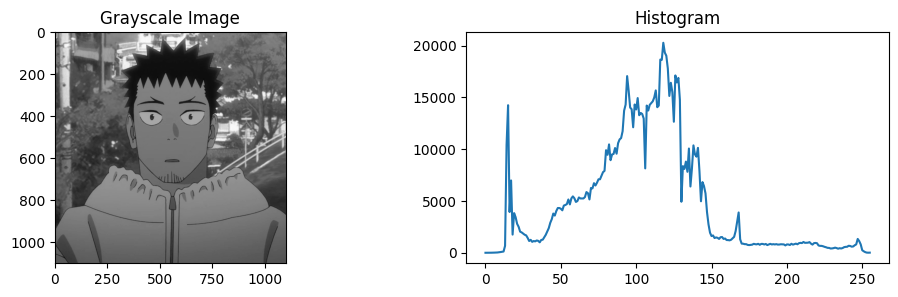

In [7]:
#histogramme de l'image en niveau de gris
#def histGrayScale(img, _xlim=255, _ylim=2400):
#   _, axes = plt.subplots(ncols=2, figsize=(12, 3))
#   ax = axes.ravel()
#    ax[0].imshow(img, cmap=plt.get_cmap('gray'))
#    ax[0].set_title('Image')
#    hist = exposure.histogram(img)
#    ax[1].plot(hist[0])
#    # to provide a better display we just change the plot display
#    ax[1].set_xlim([0, _xlim])
#    ax[1].set_ylim([0, _ylim])
#histGrayScale(image_gray)

imageHist(image_gray)

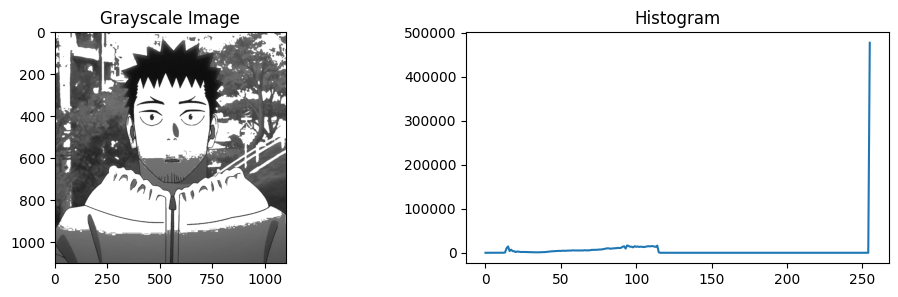

In [8]:
#Forçons tous les pixels au dessus de 120 à 255 pour voir ce que cela donne.
im = np.where(image_gray>120/256, 1, image_gray)
#histGrayScale(im, 254, 2400)
imageHist(im)

In [9]:
#statistique de l'image
def RGBStats(image):
    colors = []
    for i in range(0, 3):
        max_color =np.max(image[:,:,i])
        min_color =np.min(image[:,:,i])
        mean_color = np.mean(image[:,:,i])
        median_color = np.median(image[:,:,i])
        row = (min_color, max_color, mean_color, median_color)
        colors.append(row)
    return pd.DataFrame(colors,
                        index = ['Red', ' Green', 'Blue'],
                        columns = ['Min', 'Max', 'Mean', 'Median'])

RGBStats(image)

Min  Max        Mean  Median
Red      11  255  108.477826   106.0
 Green    8  255  111.036767   113.0
Blue      0  241   92.629583    92.0

####**Seuillage binaire sur la moyenne**
Le seuillage binaire basé sur la moyenne est une technique où le seuil est défini comme étant la valeur moyenne des intensités des pixels de l'image. Voici comment cela fonctionne :

    Calcul de la moyenne : On commence par calculer la moyenne des valeurs de gris (ou d'intensité) de tous les pixels de l'image.

    Application du seuil : Tous les pixels dont l'intensité est supérieure ou égale à cette moyenne sont définis comme blancs (valeur 1), et ceux dont l'intensité est inférieure sont définis comme noirs (valeur 0).

Le résultat est une image binaire où les objets et les zones d'intérêt peuvent être distingués du fond en fonction de leur luminosité relative par rapport à la moyenne globale de l'image. Cette méthode est simple mais peut être moins efficace si l'image contient des variations d'éclairage importantes.

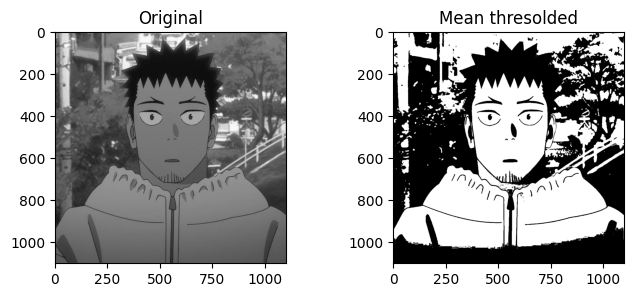

In [10]:
def thresholdMeanDisplay(image):
    thresh = threshold_mean(image)
    binary = image > thresh
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
    ax = axes.ravel()
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[1].imshow(binary, cmap=plt.cm.gray)
    ax[1].set_title('Mean thresolded')

thresholdMeanDisplay(image_gray)

####**Seuillage Otsu**
Le seuillage Otsu est une méthode automatique pour segmenter une image en niveaux de gris en deux classes (objet et fond) en déterminant un seuil optimal. Contrairement au seuillage binaire classique, où un seuil est défini manuellement ou basé sur une mesure simple (comme la moyenne), Otsu cherche à minimiser la variance intra-classe et à maximiser la variance inter-classe.

##### **Voici comment fonctionne le seuillage Otsu :**

1. **Histogramme de l'image** : On commence par analyser l'histogramme de l'image, qui montre la répartition des niveaux de gris.
   
2. **Variance intra- et inter-classe** : Le seuil optimal est celui qui sépare les pixels de l'image en deux classes (objets et fond) de manière à ce que la somme des variances intra-classe (variance au sein de chaque classe) soit minimisée. Cela revient à maximiser la variance inter-classe, c'est-à-dire la différence entre les deux classes.

3. **Seuil automatique** : La méthode Otsu trouve le seuil de manière automatique en testant différents seuils possibles et en choisissant celui qui minimise cette variance intra-classe.

Cette méthode est particulièrement utile lorsque les histogrammes des pixels de l'image sont bimodaux (deux pics distincts correspondant aux objets et au fond). Elle est largement utilisée dans des situations où on ne connaît pas à l'avance la meilleure valeur de seuil à appliquer.

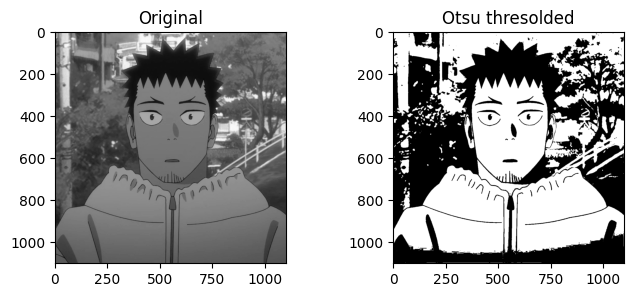

In [11]:
def thresholdOtsuDisplay(image):
    thresh = threshold_otsu(image)
    binary = image > thresh
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
    ax = axes.ravel()
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[1].imshow(binary, cmap=plt.cm.gray)
    ax[1].set_title('Otsu thresolded')

thresholdOtsuDisplay(image_gray)

####**Seuillage d'image en couleurs**

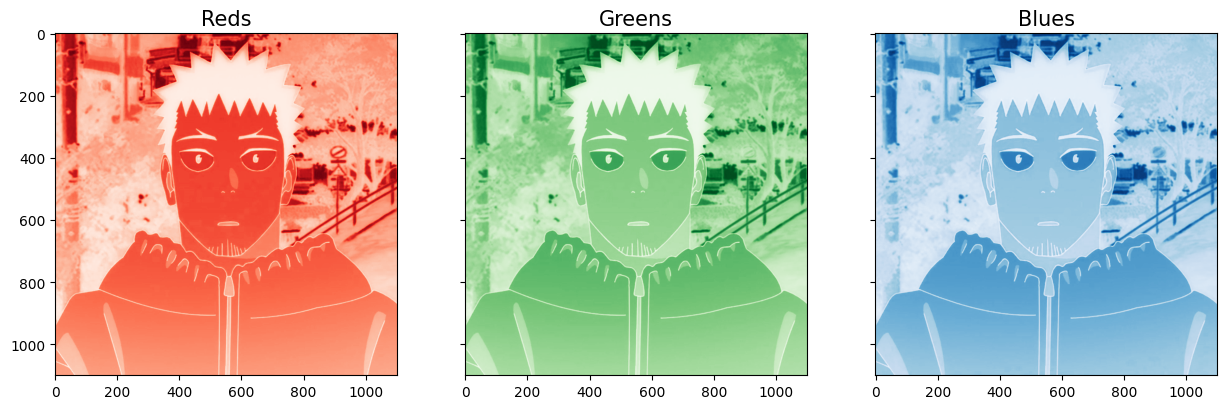

In [12]:
#Affichage de l'image avec les 3 canaux
rgb = ['Reds','Greens','Blues']
_, axes = plt.subplots(1, 3, figsize=(15,5), sharey = True)
for i in range(3):
   axes[i].imshow(image[:,:,i], cmap = rgb[i])
   axes[i].set_title(rgb[i], fontsize = 15)

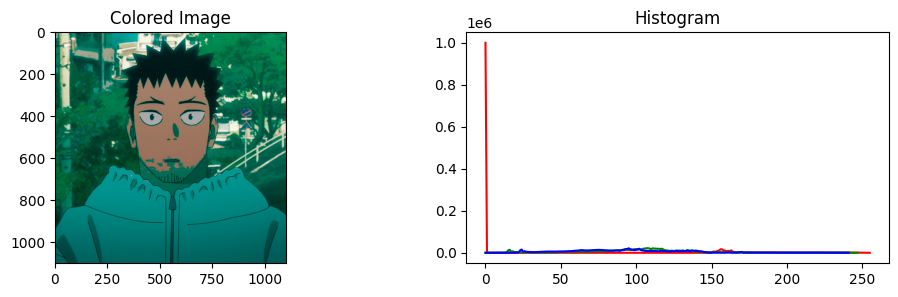

In [13]:
#Effectuons le seuillage sur le canal rouge
thresold_G = 150
image1_modified = image.copy()
image1_modified[:,:,0] = np.where(image[:,:,0]>thresold_G,
                                  image[:,:,0],
                                  0)
imageHist(image1_modified)

### **3. Les transformations d'image**
Les transformations d'image sont des opérations appliquées à une image pour la modifier d'une manière ou d'une autre, souvent à des fins d'amélioration, de segmentation ou d'analyse. Ces transformations peuvent être géométriques, photométriques ou liées à la manipulation de la couleur et des pixels.

#### **La rotation**
La roration est utilisée pour faire tourner l'image autour d'un point (généralement le centre).

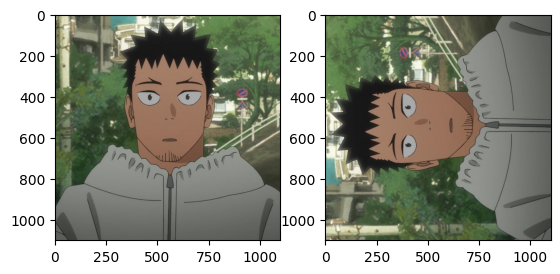

In [14]:
image_rotated = transform.rotate(image, angle=90)

fig, axes = plt.subplots(ncols=2)

axes[0].imshow(image, cmap='gray')
axes[1].imshow(image_rotated, cmap='gray')

plt.show()


#### **La redimension**
Elle permet d'augement ou de diminuer la taille d'une image

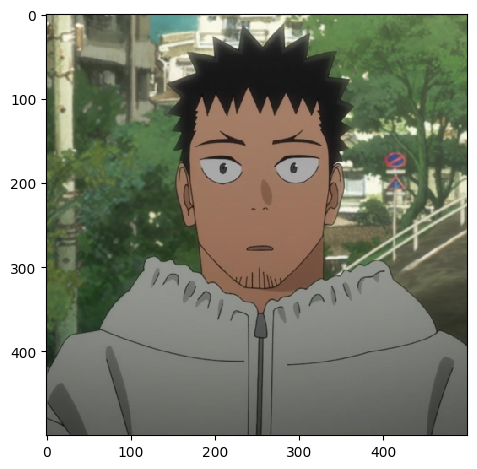

In [15]:
image_resized = transform.resize(image=image, output_shape=(500, 500, 3))
imshow(image_resized)

####**Changement d'échelle**


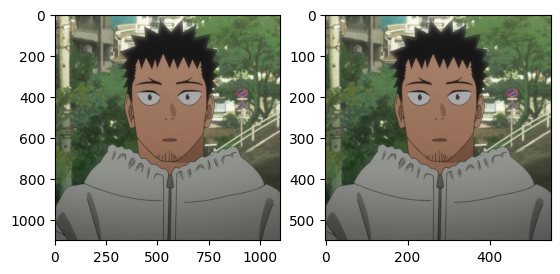

In [16]:
image_rescaled = transform.rescale(image=image, scale=1.0 / 2.0, anti_aliasing=False, channel_axis= -1)

fig, axes = plt.subplots(ncols=2)

axes[0].imshow(image, cmap='gray')
axes[1].imshow(image_rescaled, cmap='gray')

plt.show()

####**Transformation euclidienne**
La transformation SimilarityTransform() permet de combiner des transformations euclidiennes (translations) avec du changement d’echelle.

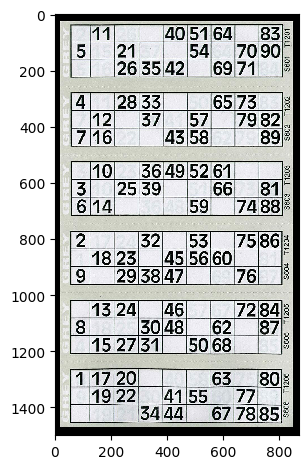

In [17]:
image2 = imread('btz3-5.jpg')
imshow(image2)

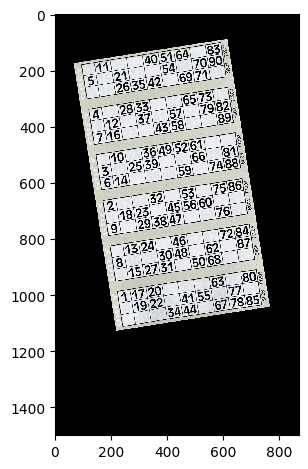

In [18]:
tr = transform.SimilarityTransform(scale=1.5, rotation=math.pi/20, translation=(-40, -250))
image_tr_1 = transform.warp(image2, tr)
imshow(image_tr_1)

### **3. Transformations morphologiques**
Commençons par la dilatation (qui correspond à un OU logique sur une image binaire), elle permet d’élargir une image. La hauteur et largeur de cette image est donc dilatée seront les sommes des hauteurs et largeurs de l’image originale et du gabarit. l’érosion est plus simple … car c’est tout simplement l’inverse (un ET logique sur une image binaire).
L’ouverture c’est la composition de l’érosion par un gabarit suivie de la dilatation par ce même gabarit.
La fermerture c’est la composition de la dilatation par un gabarit suivie de l’érosion par ce même gabarit.


####**Dilatation**

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


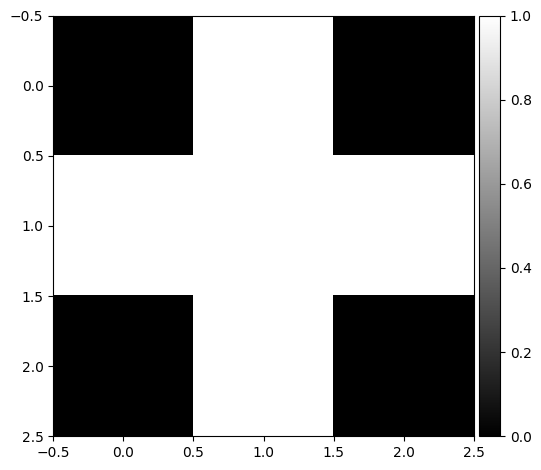

In [19]:
imshow(morphology.disk(1), cmap=plt.cm.gray)

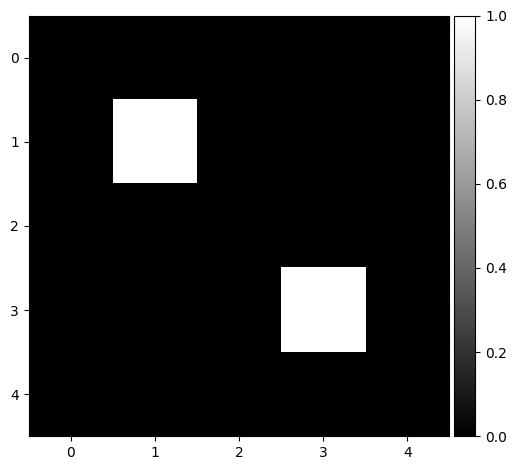

In [25]:
image_test = np.array([[0,0,0,0,0],
                       [0,1,0,0,0],
                       [0,0,0,0,0],
                       [0,0,0,1,0],
                       [0,0,0,0,0]])
imshow(image_test, cmap='gray')

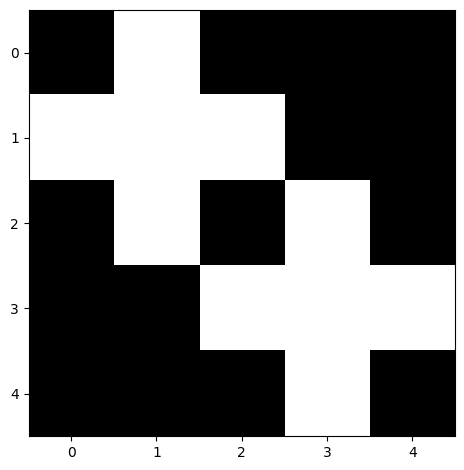

In [26]:
dilation = morphology.binary_dilation(image_test, morphology.disk(1))
imshow(dilation, cmap='gray')

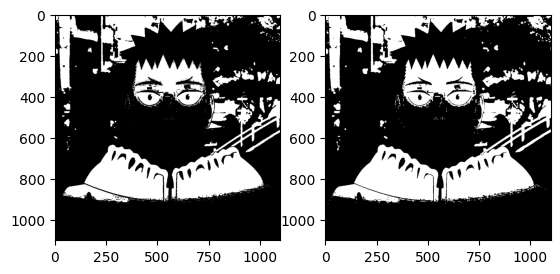

In [36]:
dilation = morphology.binary_dilation(image_nb, morphology.disk(1))
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(image_nb, cmap = 'gray')
axes[1].imshow(dilation, cmap=plt.cm.gray)
plt.show()

####**Erosion**

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


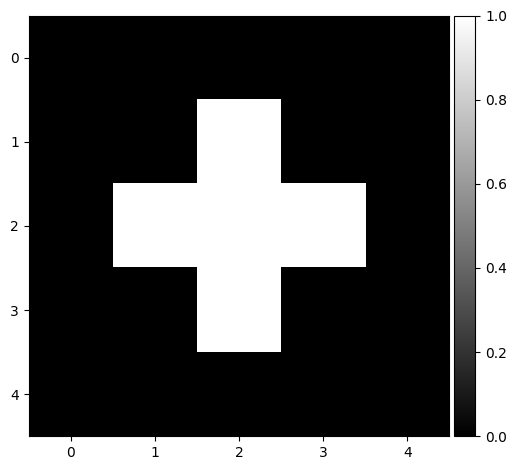

In [33]:
image_test2 = np.array([[0,0,0,0,0],
                       [0,0,1,0,0],
                       [0,1,1,1,0],
                       [0,0,1,0,0],
                       [0,0,0,0,0]])
imshow(image_test2, cmap='gray')

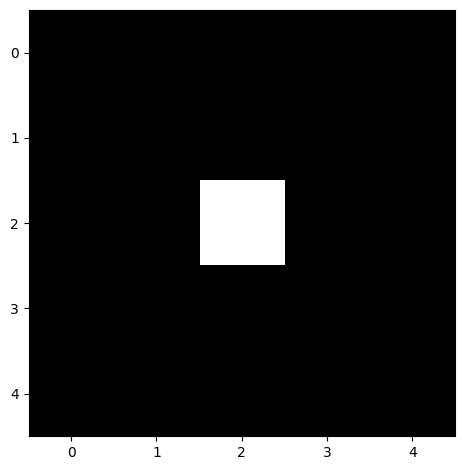

In [34]:
erosion = morphology.binary_erosion(image_test2, morphology.disk(1))
imshow(erosion, cmap='gray')

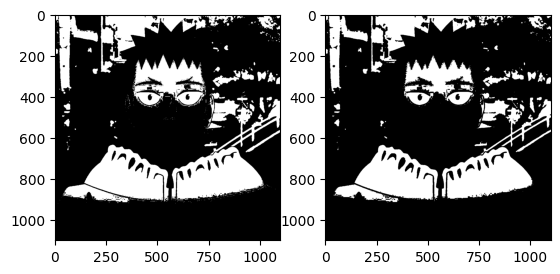

In [38]:
erosion = morphology.binary_erosion(image_nb, morphology.disk(1))

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(image_nb, cmap = 'gray')
axes[1].imshow(erosion, cmap=plt.cm.gray)
plt.show()

####**Ouverture et Fermeture**

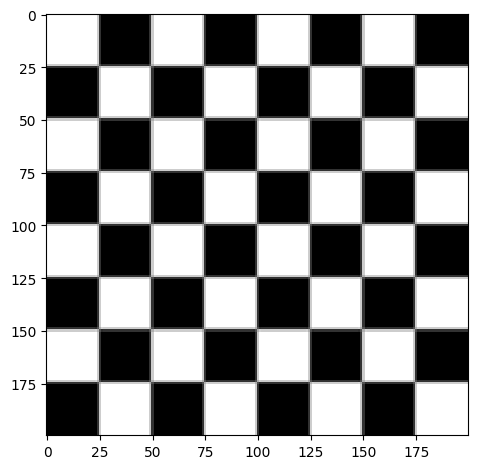

In [41]:
img =  data.checkerboard()
imshow(img, cmap='gray')

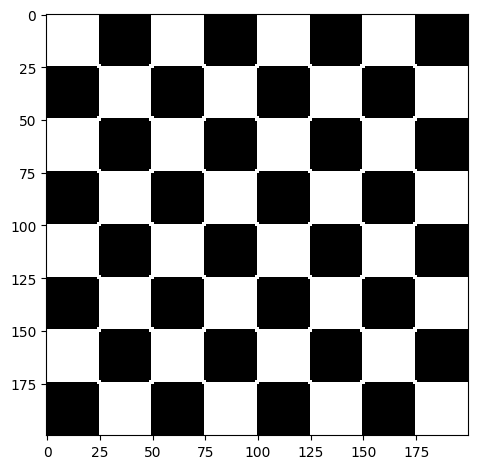

In [43]:
erosion = morphology.binary_erosion(img, morphology.disk(1))
imshow(erosion, cmap='gray')

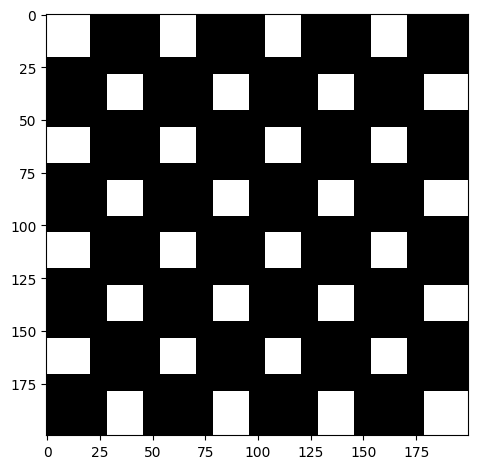

In [44]:
erosion =  data.checkerboard()
for i in range(5):
  erosion = morphology.binary_erosion(erosion, morphology.disk(1))
imshow(erosion, cmap='gray')

###**Convolution avec python**

In [48]:
def displayTwoBaWImages(img1, img2):
  _, axes = plt.subplots(ncols=2)
  axes[0].imshow(img1, cmap=plt.get_cmap('gray'))
  axes[1].imshow(img2, cmap=plt.get_cmap('gray'))

In [46]:
kernel = np.ones((3,3), np.float32)/2

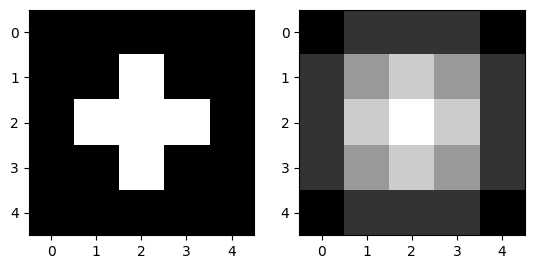

In [49]:
imgconvol = signal.convolve2d(image_test,
                              kernel,
                              mode='same',
                              boundary='fill',
                              fillvalue=0)
displayTwoBaWImages(image_test, imgconvol)

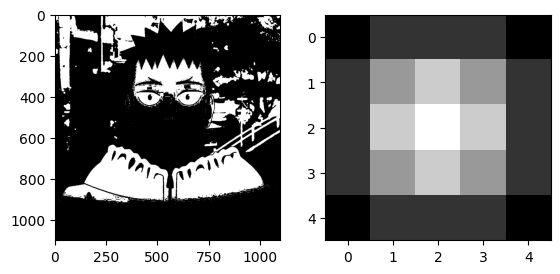

In [50]:
imgconvol2 = signal.convolve2d(image_nb,
                              kernel,
                              mode='same',
                              boundary='fill',
                              fillvalue=0)
displayTwoBaWImages(image_nb, imgconvol)

### **Détection de contours**

In [51]:
kernel_contour = np.array([[0,1,0],
                       [1,-4,1],
                       [0,1,0]])

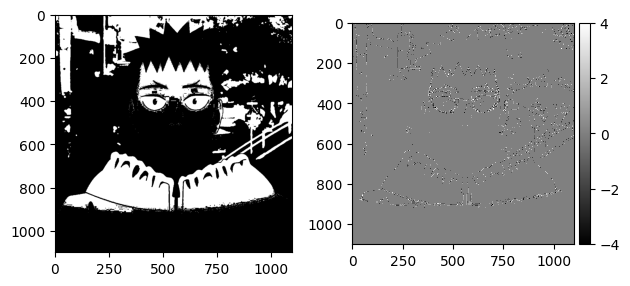

In [57]:
#Convolution
imgconvol = signal.convolve2d(image_nb,
                              kernel_contour,
                              boundary='symm',
                              mode='same')
displayTwoBaWImages(image_nb, imgconvol)
imshow(imgconvol, cmap='gray')

### **Augmentation de contraste**

In [58]:
kernel_inccontrast = np.array([[0,0,0,0,0],
                               [0,0,-1,0,0],
                               [0,-1,5,-1,0],
                               [0,0,-1,0,0],
                               [0,0,0,0,0]])

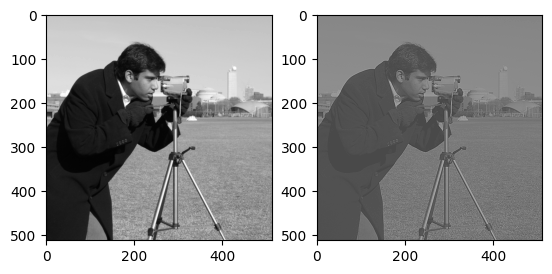

In [59]:
imgcontrast = signal.convolve2d(data.camera(),
                              kernel_inccontrast,
                              boundary='symm',
                              mode='same')
displayTwoBaWImages(data.camera(), imgcontrast)

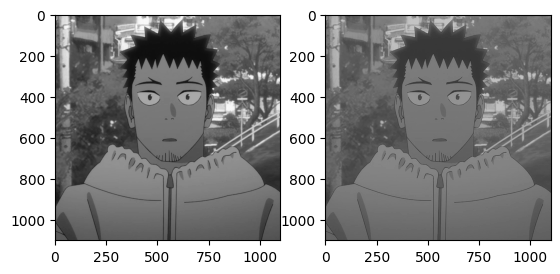

In [60]:
imgcontrast = signal.convolve2d(image_gray,
                              kernel_inccontrast,
                              boundary='symm',
                              mode='same')
displayTwoBaWImages(image_gray, imgcontrast)

###**Flouttage**

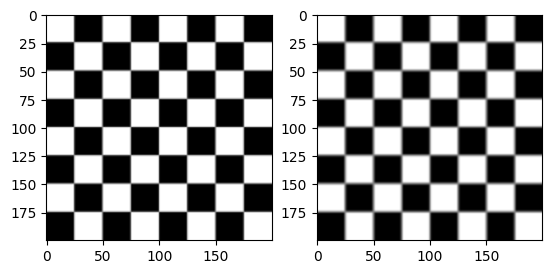

In [61]:
kernel = np.array([[0,0,0,0,0],
                    [0,1,1,1,0],
                    [0,1,1,1,0],
                    [0,1,1,1,0],
                    [0,0,0,0,0]])
img = signal.convolve2d(data.checkerboard(),
                        kernel,
                        boundary='symm',
                        mode='same')
displayTwoBaWImages(data.checkerboard(), img)

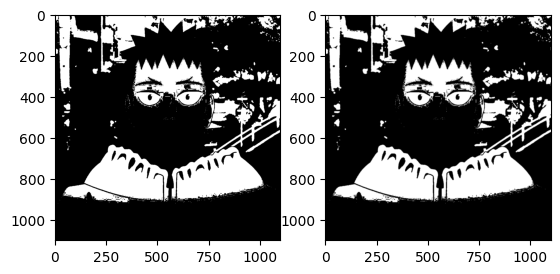

In [63]:
kernel = np.array([[0,0,0,0,0],
                    [0,1,1,1,0],
                    [0,1,1,1,0],
                    [0,1,1,1,0],
                    [0,0,0,0,0]])
img = signal.convolve2d(image_nb,
                        kernel,
                        boundary='symm',
                        mode='same')
displayTwoBaWImages(image_nb, img)

###**Renforcement de bord**

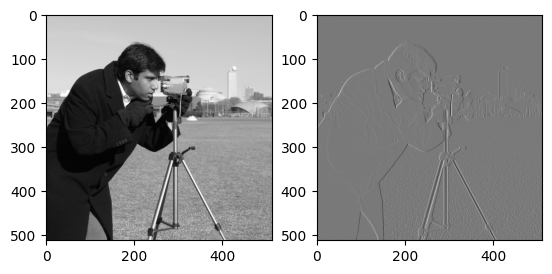

In [64]:
kernel = np.array([[0,0,0],
                   [-1,1,0,],
                   [0,0,0,]])
img = signal.convolve2d(data.camera(),
                        kernel,
                        boundary='symm',
                        mode='same')
displayTwoBaWImages(data.camera(), img)

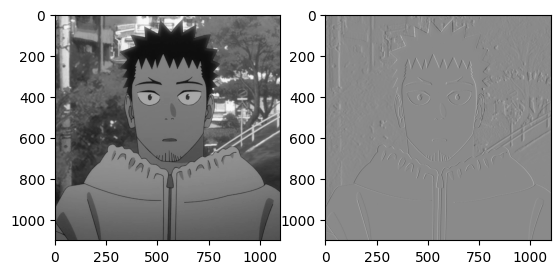

In [65]:
kernel = np.array([[0,0,0],
                   [-1,1,0,],
                   [0,0,0,]])
img = signal.convolve2d(image_gray,
                        kernel,
                        boundary='symm',
                        mode='same')
displayTwoBaWImages(image_gray, img)

---

##**Réseau de neurones à convolution**

In [71]:
import tensorflow as tf

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model

In [72]:
#Division en données test et train
dataset_fashion_mnsit = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = dataset_fashion_mnsit.load_data()

In [73]:
#Repartition des étiquettes
pd.DataFrame(y_train)[0].value_counts()

0
9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
Name: count, dtype: int64

In [74]:
#Normalisation des données
X_train = X_train / 255
X_test = X_test / 255
print(f"Données entrainement: {X_train.shape}, Test: {X_test.shape}")

Données entrainement: (60000, 28, 28), Test: (10000, 28, 28)


9

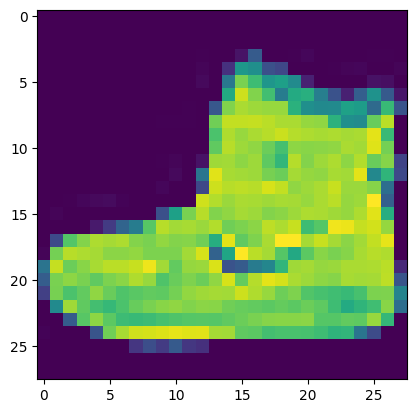

In [77]:
#affichage d'une image
plt.imshow(X_train[0])
y_train[0]

In [76]:
#Ajout de dimensions
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

In [78]:
#Création du model

mon_cnn = tf.keras.Sequential()

# 3 couches de convolution, avec Nb filtres progressif 32, 64 puis 128
mon_cnn.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(28, 28, 1), activation='relu'))
mon_cnn.add(MaxPooling2D(pool_size=(2, 2)))

mon_cnn.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(28, 28, 1), activation='relu'))
mon_cnn.add(MaxPooling2D(pool_size=(2, 2)))

mon_cnn.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(28, 28, 1), activation='relu'))
mon_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# remise à plat
mon_cnn.add(Flatten())

# Couche dense classique ANN
mon_cnn.add(Dense(512, activation='relu'))

# Couche de sortie (classes de 0 à 9)
mon_cnn.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [80]:
#Compilons

mon_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
mon_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,154 (367.79 KB)

 Trainable params: 94,154 (367.79 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
#Entrainement
mon_cnn.fit(x=X_train,
            y=y_train,
            validation_data=(X_test, y_test),
            epochs=25,
            callbacks=[early_stop])

Epoch 1/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 62s 31ms/step - accuracy: 0.7210 - loss: 0.7635 - val_accuracy: 0.8468 - val_loss: 0.4297
Epoch 2/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - accuracy: 0.8508 - loss: 0.4001 - val_accuracy: 0.8626 - val_loss: 0.3822
Epoch 3/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.8785 - loss: 0.3311 - val_accuracy: 0.8734 - val_loss: 0.3480
Epoch 4/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 30ms/step - accuracy: 0.8919 - loss: 0.2885 - val_accuracy: 0.8748 - val_loss: 0.3415
Epoch 5/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.8988 - loss: 0.2710 - val_accuracy: 0.8827 - val_loss: 0.3165
Epoch 6/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 30ms/step - accuracy: 0.9073 - loss: 0.2472 - val_accuracy: 0.8891 - val_loss: 0.3083
Epoch 7/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - accuracy: 0.9145 - loss: 0.2271 - val_accuracy: 0.8857 - val_loss: 0.3179
Epoch 8/25
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - accuracy: 0.9203 -

<Axes: >

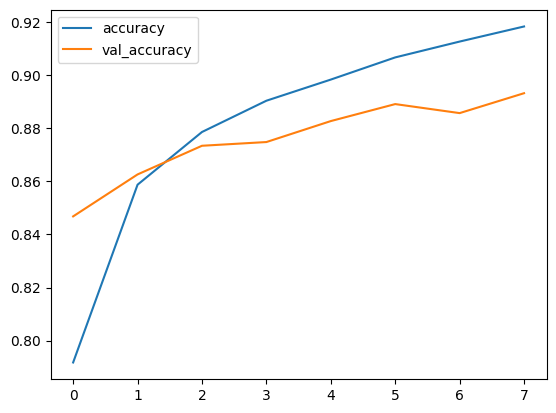

In [82]:
#evaluation du model
losses = pd.DataFrame(mon_cnn.history.history)
losses[['accuracy', 'val_accuracy']].plot()

<Axes: >

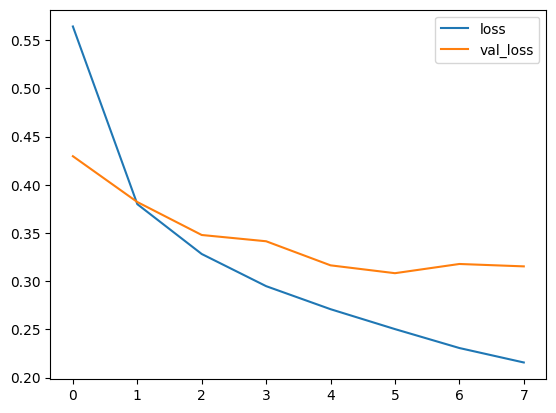

In [83]:
losses[['loss', 'val_loss']].plot()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


<Axes: >

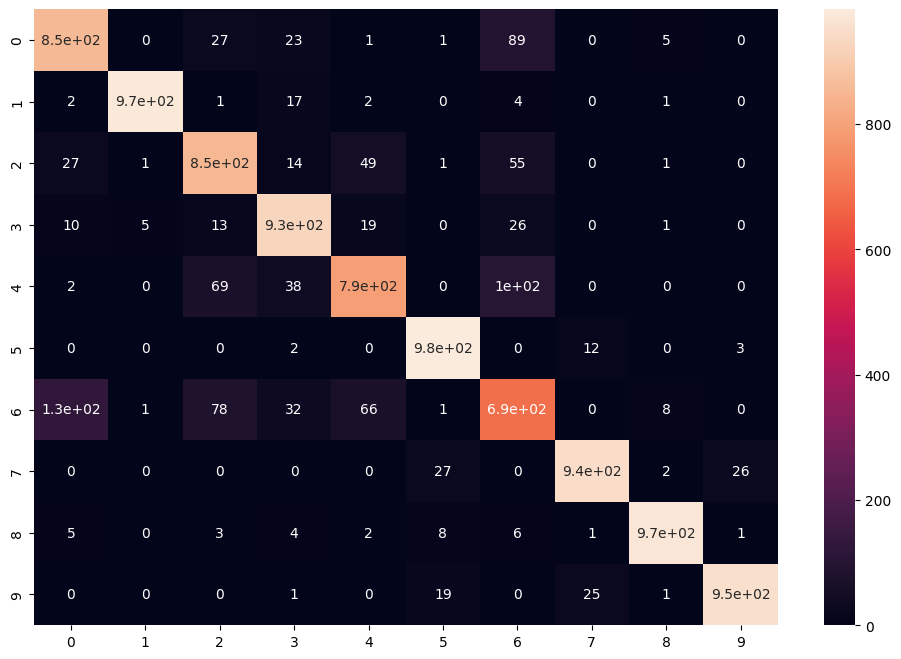

In [90]:
plt.figure(figsize=(12,8))
pred = mon_cnn.predict(X_test)
pred = np.argmax(pred, axis=1)
sns.heatmap(confusion_matrix(y_test, pred),annot=True)

In [91]:
img = X_train[0]
mon_cnn.predict(img.reshape(1,28,28,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[2.0227308e-08, 2.0447420e-10, 1.0376895e-08, 3.3678841e-08,
        6.6013584e-08, 1.3704193e-06, 2.8167218e-08, 1.9706176e-03,
        4.5773831e-08, 9.9802786e-01]], dtype=float32)

In [92]:
np.argmax(mon_cnn.predict(img.reshape(1,28,28,1)), axis=-1)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


9